In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from lib import *
from lib.maxent import *
from lib.plotting import *
plt.style.use('../peptidome.mplstyle')

%load_ext autoreload
%autoreload 2

In [2]:
k = 9
ref = 'human'

In [3]:
matrix = load_matrix('../maxent/data/test_matrix.csv.gz')

In [4]:
params = np.load('../maxent/data/Human_reference_9.npz')
hi = params['hi']
Jij = params['Jij']

In [5]:
likelihood_human = np.array([-energy_potts(x, hi, Jij) for x in matrix])

In [6]:
with open(datadir+ 'triplet-%s.json' % ref, 'r') as f:
    tripletparams = json.load(f)
loglikelihood = lambda seq, k: -energy_potts(map_aatonumber(seq.upper()), hi, Jij)
likelihoodname = 'maxent'

In [7]:
df_ts = load_iedb_tcellepitopes()

In [8]:
host = 'Homo sapiens'
#host = 'Mus musculus'
mask_host_host = df_ts['Host', 'Name'].str.contains(host, na=False)
# no host epitopes or epitopes of unknown provenance
mask_epitope_host = df_ts['Epitope', 'Parent Species'].str.contains(host, na=True)
df_ts = df_ts[mask_host_host & (~mask_epitope_host)]

In [9]:
# uniquify epitopes by keeping only the first one
df_ts = df_ts.groupby(('Epitope', 'Description')).apply(lambda x: x.iloc[0])

(array([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 7.0000e+00,
        1.1000e+01, 1.6000e+01, 3.6900e+02, 8.5280e+03, 4.5240e+03,
        3.8900e+02, 2.0290e+03, 8.9100e+02, 1.0910e+03, 4.3846e+04,
        1.4740e+03, 2.2780e+03, 4.0540e+03, 5.3900e+02, 5.2120e+03,
        2.8400e+02, 1.2700e+02, 9.4000e+01]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5]),
 <a list of 23 Patch objects>)

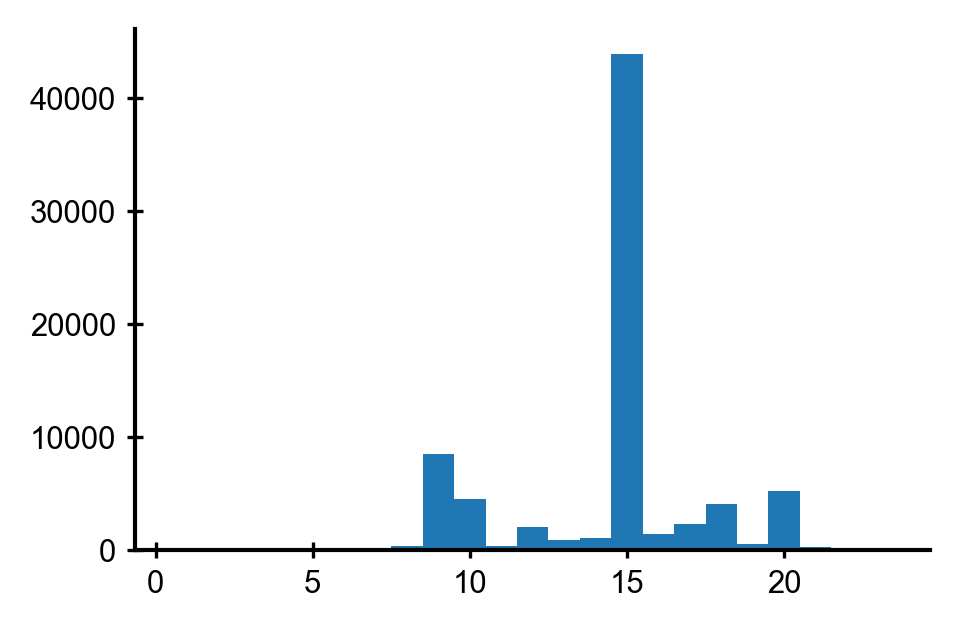

In [10]:
plt.hist(df_ts['Epitope', 'Description'].str.len(), bins=np.arange(1, 25, 1)-0.5)

In [12]:
xmin = likelihood_human.min()
xmax = likelihood_human.max()
hists_pos = {}
hists_neg = {}
lengths = [9, 15]
for length in lengths:
    positive = ~(df_ts['Assay', 'Qualitative Measure'] == 'Negative')
    lengthmask = np.abs(df_ts['Epitope', 'Description'].str.len()-length)<2
    likelihoods_t, weights_t = likelihoods_epitopes(df_ts[positive & lengthmask]['Epitope', 'Description'], loglikelihood, k)
    likelihoods_t_neg, weights_t_neg = likelihoods_epitopes(df_ts[(~positive) & lengthmask]['Epitope', 'Description'], loglikelihood, k)

    bins = list(np.linspace(xmin+3, xmax-8, 25))
    bins.extend([xmin-0.1, xmax+0.1])
    bins = np.array(sorted(bins))
    binmids = (bins[1:]+bins[:-1])*0.5
    hists_pos[length] = np.histogram(likelihoods_t, bins=bins, weights=weights_t)[0]
    hists_neg[length]= np.histogram(likelihoods_t_neg, bins=bins, weights=weights_t_neg)[0]

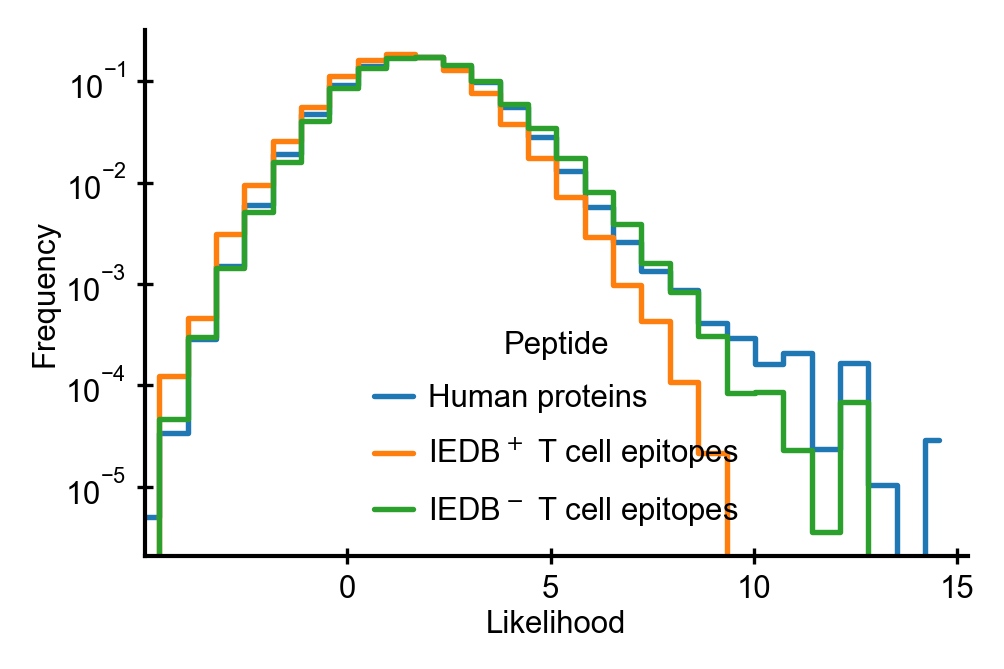

In [13]:
fig, ax = plt.subplots()
ps = [likelihood_human, likelihoods_t, likelihoods_t_neg]#, likelihoods_b]
labels = ['Human proteins', 'IEDB$^+$ T cell epitopes', 'IEDB$^-$ T cell epitopes']#, 'B epitopes']
weights = [np.ones(len(likelihood_human)), weights_t, weights_t_neg]#, weights_b]

plot_histograms(ps, labels, weights=weights, xmin=xmin, xmax=xmax, ax=ax, nbins=30)
ax.set_xlim(xmin, xmax)
ax.set_ylabel('Frequency')
ax.set_xlabel('Likelihood')
ax.set_yscale('log')
ax.legend(title='Peptide', loc='lower center')
fig.tight_layout()

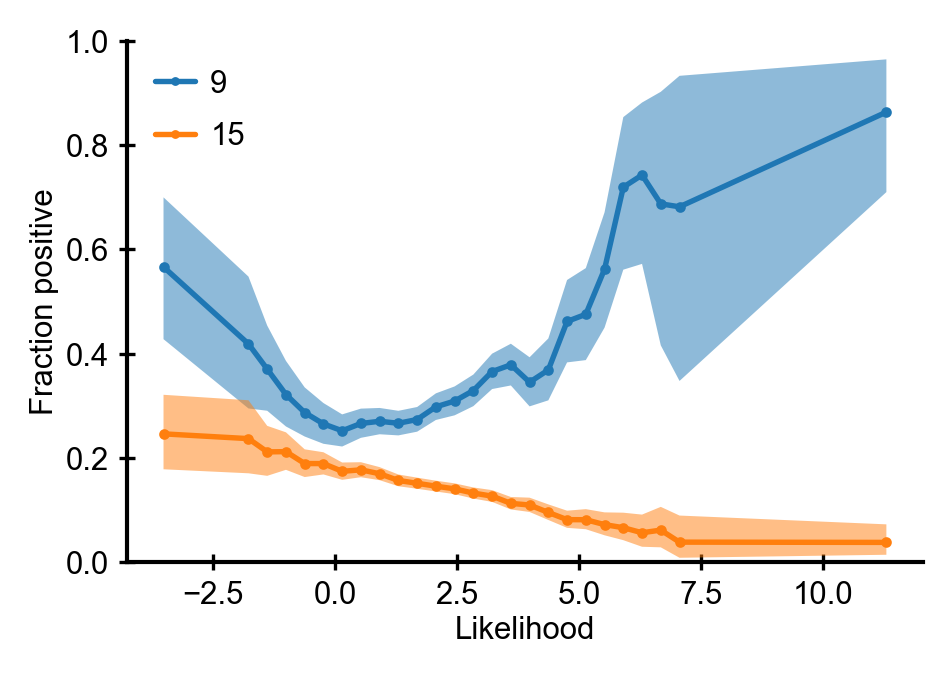

In [14]:
fig, ax = plt.subplots()
for length in lengths:
    hist_pos, hist_neg = hists_pos[length], hists_neg[length]
    plot_proportion(binmids, hist_pos, hist_pos+hist_neg, ls='-', marker='.', ax=ax, label=length)
ax.set_xlabel('Likelihood')
ax.set_ylabel('Fraction positive')
ax.legend()
ax.set_ylim(0.0, 1.0)
fig.savefig('maxent_iedb_fraction_positive.png')